In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold


from sklearn.metrics import roc_auc_score


from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


In [19]:
#   _id - идентификатор человека
#   age - возраст
#   job - тип работы ("admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
#   marital - семейное положение ("divorced" (разведенный и овдовевший),"married","single","unknown")
#   education - уровень образования ("basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
#   default - есть ли дефолт по кредиту ("no","yes","unknown")
#   housing - есть ли кредит на жилье ("no","yes","unknown")
#   loan - есть ли персональный кредит ("no","yes","unknown")
#   contact - контактный тип связи ("cellular","telephone")
#   month - последний контактный месяц года ("jan", "feb", "mar", ..., "nov", "dec")
#   day_of_week - последний контактный день недели ("mon","tue","wed","thu","fri")
#   duration - длительность последнего контакта в секундах. (Важное замечание: этот атрибут сильно влияет на таргет (например, если длительность - 0 сек., то таргет - 0). Тем не менее, продолжительность не известна до выполнения вызова.
#   campaign - количество контактов, выполненных для этого клиента в рамках текущей маркетинговой кампании (включая последний контакт)
#   pdays - количество дней прошедших последнего контакта с клиентом с предыдущей маркетинговой кампании (999 означает, что ранее с клиентом не контактировали)
#   previous - количество контактов, выполненных до текущей маркетинговой кампании для этого клиента
#   poutcome - результат предыдущей маркетинговой кампании ("failure","nonexistent","success")
#   # ниже приведены показатели окружающей среды и банка
#   emp.var.rate - изменение уровня занятости (квартальный показатель)
#   cons.price.idx - индекс потребительских цен (ежемесячный показатель)
#   cons.conf.idx - индекс доверия потребителя (ежемесячный показатель)
#   euribor3m - курс Euribor (ежедневный показатель)
#   nr.employed - количество сотрудников (квартальный показатель)
#   target - целевая переменная (таргет) - согласился ли клиент на вклад (депозит)

In [20]:
df = pd.read_csv('train.csv', sep=',')
df.axes

[RangeIndex(start=0, stop=24712, step=1),
 Index(['_id', 'age', 'job', 'marital', 'education', 'default', 'housing',
        'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
        'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'nr.employed', 'target'],
       dtype='object')]

In [21]:
df.head()

,_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,df7489733b004bbe40d3d37b34f82419,54,technician,married,professional.course,unknown,no,no,cellular,aug,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,905a0b9a5456ee962223033473666be3,36,services,single,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,02d69c07ec6d68e31d641edd45ce61cd,53,blue-collar,married,basic.4y,no,yes,no,cellular,aug,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0
3,e492fbe0cccaf67cdb5c0944dbc8a167,34,blue-collar,married,basic.9y,no,yes,yes,telephone,may,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,ac2dc6f5835bdea8e71dd99b65208d07,29,services,single,university.degree,no,yes,no,telephone,aug,...,1,999,0,nonexistent,-1.7,94.027,-38.3,0.890,4991.6,0


In [22]:
def preproc(df_init):
    df_preproc = df_init.copy()
    
    dummy_columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
    df_preproc = pd.get_dummies(df_preproc, columns=dummy_columns)
    
    TARGET_DF = df_preproc['target']
    df_preproc = df_preproc.drop(['_id'
                                #  , 'job'
                                #  , 'marital'
                                #  , 'education'
                                # # , 'default'
                                # # , 'housing'
                                # # , 'loan'
                                #  , 'contact'
                                #  , 'month'
                                #  , 'day_of_week'
                                #  , 'poutcome'
                                  , 'target'
                                 ], axis=1)
    
    # Замена категориальных признаков
    df_preproc.loc[:, ['default', 'housing', 'loan']] = \
    df_preproc.loc[:, ['default', 'housing', 'loan']].replace({"no": 0
                                                               ,"yes": 1
                                                               ,"unknown": 0.5})
    
    
    return df_preproc, TARGET_DF



In [23]:
df_preproc, target_df = df.pipe(preproc)
X_, y_= df_preproc.iloc[:, :].values, target_df.values

X, X_test, y, y_test = train_test_split(X_, y_, test_size=0.3, random_state=123)
df_preproc.head()
print(X_.shape, X_test.shape, y.shape, y_test.shape)

(24712, 57) (7414, 57) (17298,) (7414,)


In [24]:
model = LogisticRegression(random_state=123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

train_scores, valid_scores = validation_curve(model, X, y, 
                                              'C', range(10, 15),
                                              cv=cv, scoring='roc_auc')

Text(0,0.5,'ROC AUC')

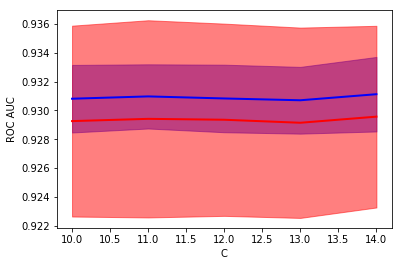

In [25]:
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(10,15), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(10,15), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(10,15), train_score_mean, c='b', lw=2)
plt.plot(range(10,15), valid_scores_mean, c='r', lw=2)

plt.xlabel('C')
plt.ylabel('ROC AUC')

#best_model = random_search.best_estimator_

In [26]:
# Определим пространство поиска

param_grid = {
    'C': randint(10, 18),
    'tol': [1e-4, 1e-5, 1e-3],
    'class_weight': [None, 'balanced']}

# Некоторые параметры мы задали не простым перечислением значений, а 
# с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = LogisticRegression(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)
# А дальше, просто .fit()
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x111429358>, 'tol': [0.0001, 1e-05, 0.001], 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [27]:
random_search.best_params_

{'C': 16, 'class_weight': 'balanced', 'tol': 1e-05}

In [28]:
random_search.best_score_

0.9351129977524282

In [29]:
best_model = random_search.best_estimator_

In [30]:
model = random_search.best_estimator_

In [31]:
#pd.Series(index=df_preproc.columns[:-1], data=imp).sort_values()

In [32]:
res = model.predict(X_test)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, res))
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, res)

             precision    recall  f1-score   support

          0       0.98      0.86      0.92      6574
          1       0.45      0.87      0.59       840

avg / total       0.92      0.86      0.88      7414



0.8644456433773942